<a href="https://colab.research.google.com/github/kurek0010/neural-network-course/blob/master/06_cnn/03_multiple_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Klasyfikator wieloklasowy - Image Classification - Drone vs. Passenger Plane vs. Helicopter

1. [Import bibliotek](#a0)
2. [Załadowanie danych](#a1)
3. [Przygotowanie zbiorów: treningowego, walidacyjnego i testowego](#a2)
4. [Eksplorcja danych](#a3)
5. [Augmentacja danych](#a4)
6. [Budowa modelu](#a5)
7. [Transfer learning - model VGG16](#a6)
8. [Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw](#a7)
9. [Ocena modelu na zbiorze testowym](#a8)
10. [Wyświetlenie błędów predykcji](#a9)

### <a name='a0'></a> Import bibliotek

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19

np.set_printoptions(precision=6, suppress=True)

### <a name='a1'></a> Załadowanie danych

In [2]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

--2025-02-13 14:36:20--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  24.9MB/s    in 60s     

2025-02-13 14:37:20 (24.7 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



### <a name='a2'></a> Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [3]:
!rm -rf ./images

In [4]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [5]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')
train_helicopter_dir = os.path.join(train_dir, 'helicopter')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')
valid_helicopter_dir = os.path.join(valid_dir, 'helicopter')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')
test_helicopter_dir = os.path.join(test_dir, 'helicopter')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, train_helicopter_dir,
        valid_drone_dir, valid_passenger_dir, valid_helicopter_dir,
        test_drone_dir, test_passenger_dir, test_helicopter_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [6]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))
helicopter_fnames = os.listdir(os.path.join(base_dir, 'helicopter'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
helicopter_fnames = [fname for fname in helicopter_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [7]:
size = min(len(drone_fnames), len(passenger_fnames), len(helicopter_fnames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [8]:
for i, fname in enumerate(drone_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(helicopter_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'helicopter', fname)
        dst = os.path.join(train_helicopter_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'helicopter', fname)
        dst = os.path.join(valid_helicopter_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'helicopter', fname)
        dst = os.path.join(test_helicopter_dir, fname)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

print('helicopter - zbiór treningowy', len(os.listdir(train_helicopter_dir)))
print('helicopter - zbiór walidacyjny', len(os.listdir(valid_helicopter_dir)))
print('helicopter - zbiór testowy', len(os.listdir(test_helicopter_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131
helicopter - zbiór treningowy 919
helicopter - zbiór walidacyjny 262
helicopter - zbiór testowy 131


### <a name='a3'></a> Eksplorcja danych

(-0.5, 2399.5, 1259.5, -0.5)

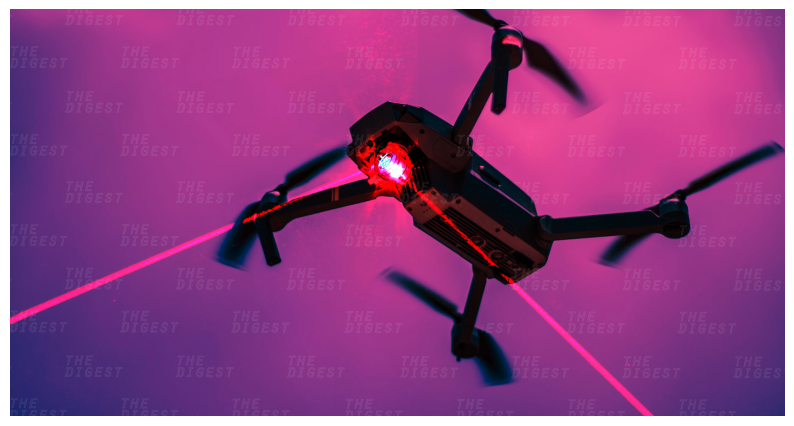

In [9]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 133 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 899.5, 599.5, -0.5)

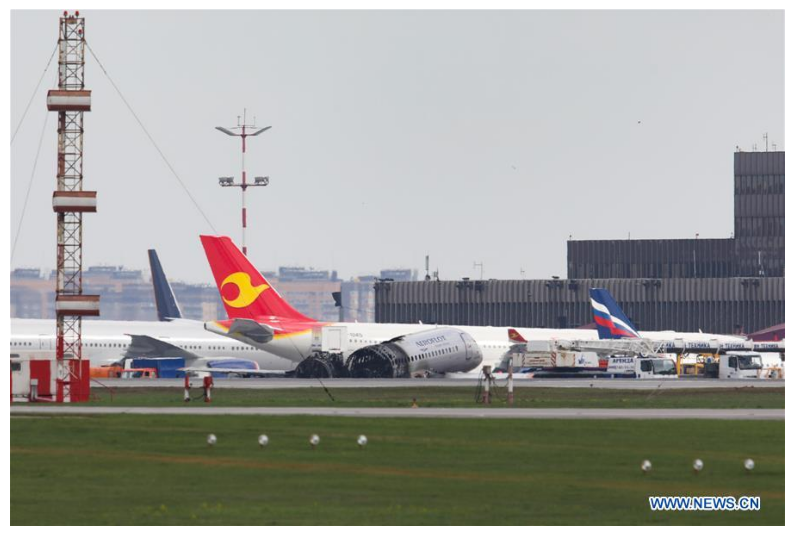

In [10]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 97 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 299.5, 194.5, -0.5)

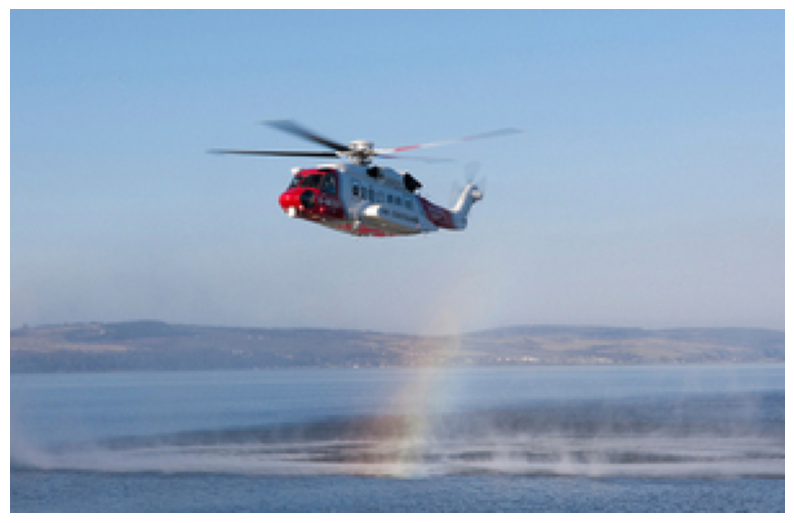

In [11]:
#@title Wybierz indeks przykładowego zdjęcia helikoptera ze zbioru treningowego:

idx = 621 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(helicopter_fnames))
img_path = os.path.join(train_helicopter_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### <a name='a4'></a> Augmentcja danych

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=40,      # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 2757 images belonging to 3 classes.
Found 786 images belonging to 3 classes.


In [13]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

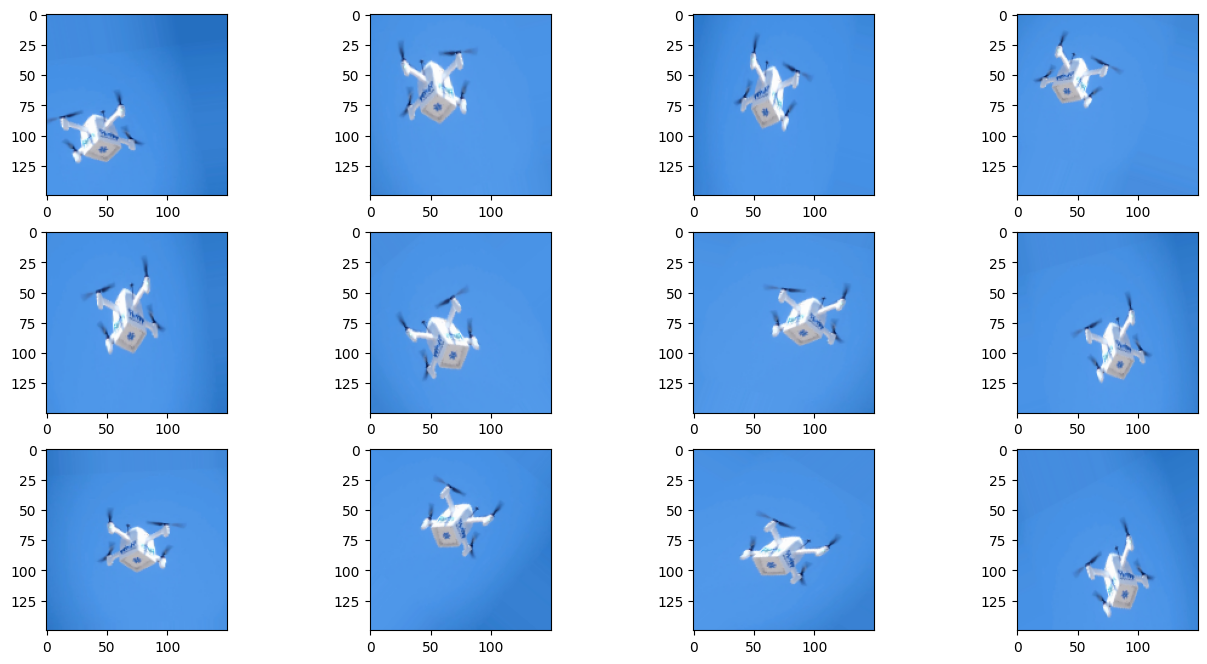

In [14]:
#@title Zbiór treningowy drone:
idx = 131 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_drone_dir, idx)

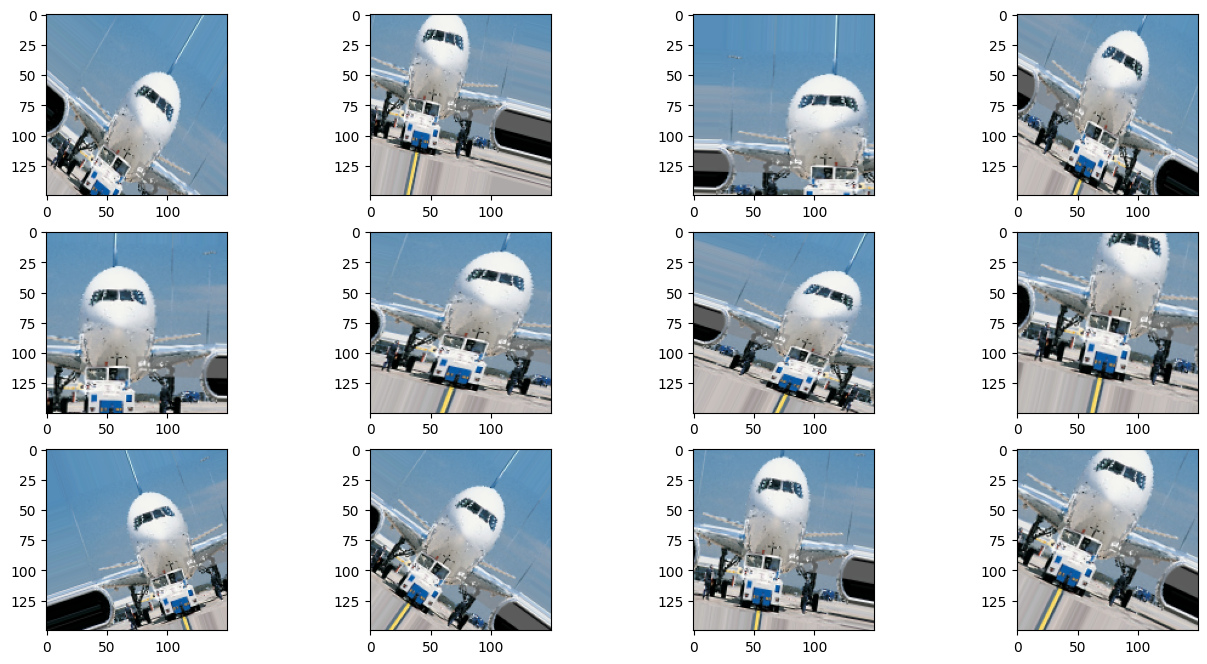

In [15]:
#@title Zbiór treningowy passenger:
idx = 777 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

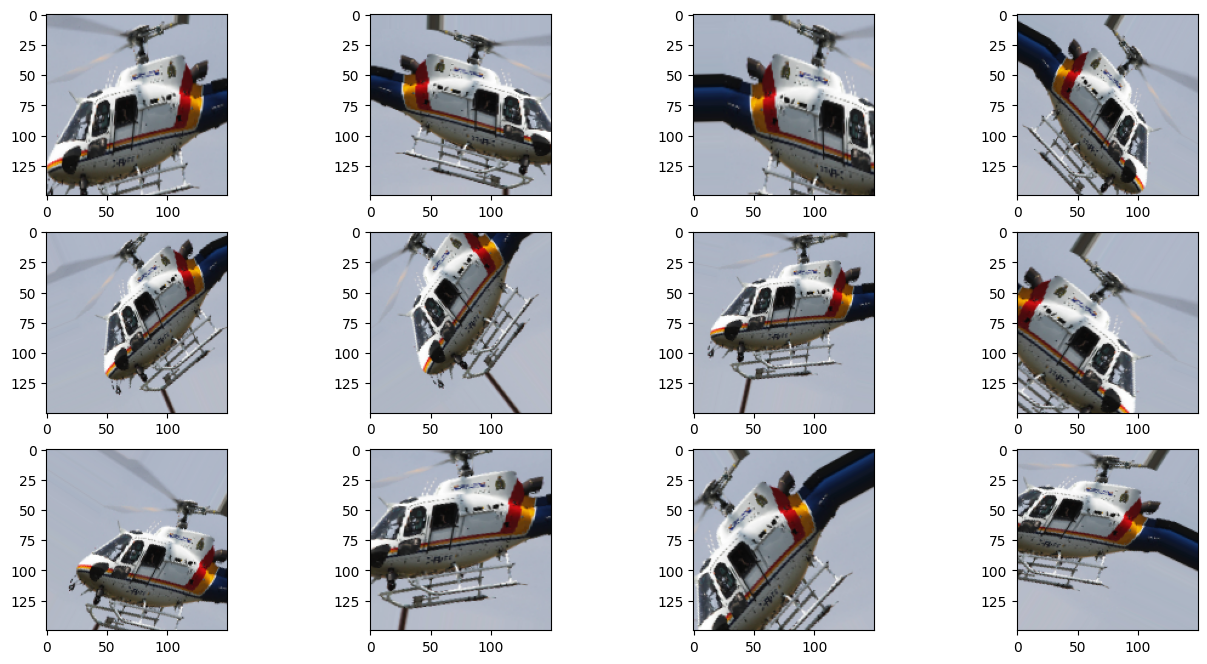

In [16]:
#@title Zbiór treningowy passenger:
idx = 567 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_helicopter_dir, idx)

### <a name='a5'></a> Budowa modelu

In [17]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

### <a name='a7'></a> Transfer learning - model VGG19 - odmrożenie kilku ostatnich warstw

In [18]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
layer_name: input_layer   trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [19]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_layer   trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [22]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,122,563 (84.39 MB)

 Trainable params: 11,537,411 (44.01 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

In [24]:
history = model.fit(train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 644ms/step - accuracy: 0.4008 - loss: 1.0731 - val_accuracy: 0.5156 - val_loss: 0.9321
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 735ms/step - accuracy: 0.5404 - loss: 0.9457 - val_accuracy: 0.6758 - val_loss: 0.7785
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 739ms/step - accuracy: 0.6589 - loss: 0.7828 - val_accuracy: 0.7031 - val_loss: 0.6886
Epoch 4/30
 3/28 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.7917 - loss: 0.6424

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.7824 - loss: 0.6626 - val_accuracy: 0.7188 - val_loss: 0.6909
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6786 - loss: 0.7208 - val_accuracy: 0.6641 - val_loss: 0.7251
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 562ms/step - accuracy: 0.6907 - loss: 0.7187 - val_accuracy: 0.7656 - val_loss: 0.5922
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 722ms/step - accuracy: 0.6999 - loss: 0.6930 - val_accuracy: 0.7852 - val_loss: 0.6054
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5919 - loss: 0.7617 - val_accuracy: 0.6836 - val_loss: 0.7236
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 905ms/step - accuracy: 0.7192 - loss: 0.6365 - val_accuracy: 0.7266 - val_loss: 0.6521
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 767ms/step - accuracy: 0.6951 - loss: 0.6602 - val_accuracy: 0.7695 - val_loss: 0.5979
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.7503 - loss: 0.5918 - val_accuracy: 0.7852 - 

In [25]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

### <a name='a8'></a> Ocena modelu na zbiorze testowym

In [27]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict(test_generator, test_generator.samples)
y_prob

Found 393 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



393/393 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step


array([[0.995655, 0.003455, 0.00089 ],
       [0.901603, 0.017737, 0.08066 ],
       [0.967203, 0.01334 , 0.019457],
       ...,
       [0.005495, 0.066344, 0.928161],
       [0.000308, 0.057568, 0.942123],
       [0.372391, 0.216701, 0.410908]], dtype=float32)

In [28]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,

In [29]:
predictions  = pd.DataFrame({'class': y_pred})
predictions

class
0        0
1        0
2        0
3        0
4        0
..     ...
388      0
389      2
390      2
391      2
392      2

[393 rows x 1 columns]

In [30]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [31]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,

In [32]:
test_generator.class_indices

{'drone': 0, 'helicopter': 1, 'passenger': 2}

In [33]:
classes = list(test_generator.class_indices.keys())
classes

['drone', 'helicopter', 'passenger']

In [34]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[105,  13,  13],
       [  5, 119,   7],
       [ 16,  18,  97]])

In [35]:
def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

In [36]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

       drone       0.83      0.80      0.82       131
  helicopter       0.79      0.91      0.85       131
   passenger       0.83      0.74      0.78       131

    accuracy                           0.82       393
   macro avg       0.82      0.82      0.82       393
weighted avg       0.82      0.82      0.82       393



### <a name='a9'></a> Wyświetlenie błędów predykcji

In [37]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

y_true  y_pred
drone/00000054.jpeg          0       0
drone/00000056.jpg           0       0
drone/00000060.jpg           0       0
drone/00000065.jpg           0       0
drone/00000069.jpg           0       0
...                        ...     ...
passenger/00001445.jpg       2       0
passenger/00001450.jpg       2       2
passenger/00001472.jpg       2       2
passenger/00001478.jpg       2       2
passenger/00001489.jpg       2       2

[393 rows x 2 columns]

In [38]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

y_true  y_pred  is_incorrect
drone/00000054.jpeg          0       0             0
drone/00000056.jpg           0       0             0
drone/00000060.jpg           0       0             0
drone/00000065.jpg           0       0             0
drone/00000069.jpg           0       0             0
...                        ...     ...           ...
passenger/00001445.jpg       2       0             1
passenger/00001450.jpg       2       2             0
passenger/00001472.jpg       2       2             0
passenger/00001478.jpg       2       2             0
passenger/00001489.jpg       2       2             0

[393 rows x 3 columns]

In [39]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000095.jpg', 'drone/00000219.jpg', 'drone/00000279.jpg',
       'drone/00000303.jpg', 'drone/00000417.jpg', 'drone/00000477.jpg',
       'drone/00000525.png', 'drone/00000591.jpg', 'drone/00000652.jpg',
       'drone/00000680.jpg', 'drone/00000765.JPG', 'drone/00000799.png',
       'drone/00000893.jpg', 'drone/00000907.jpg', 'drone/00000954.jpg',
       'drone/00000978.jpg', 'drone/00000987.jpg', 'drone/00001052.jpg',
       'drone/00001210.jpg', 'drone/00001246.jpg', 'drone/00001247.jpg',
       'drone/00001277.jpg', 'drone/00001364.jpg', 'drone/00001367.jpg',
       'drone/00001370.jpg', 'drone/00001390.jpg', 'helicopter/00000129.jpg',
       'helicopter/00000153.jpg', 'helicopter/00000333.jpg',
       'helicopter/00000369.jpg', 'helicopter/00000464.jpg',
       'helicopter/00000542.jpg', 'helicopter/00000623.jpg',
       'helicopter/00000712.jpg', 'helicopter/00000895.jpg',
       'helicopter/00001188.jpeg', 'helicopter/00001363.png',
       'helicopter/00001445.jpg'

(-0.5, 604.5, 604.5, -0.5)

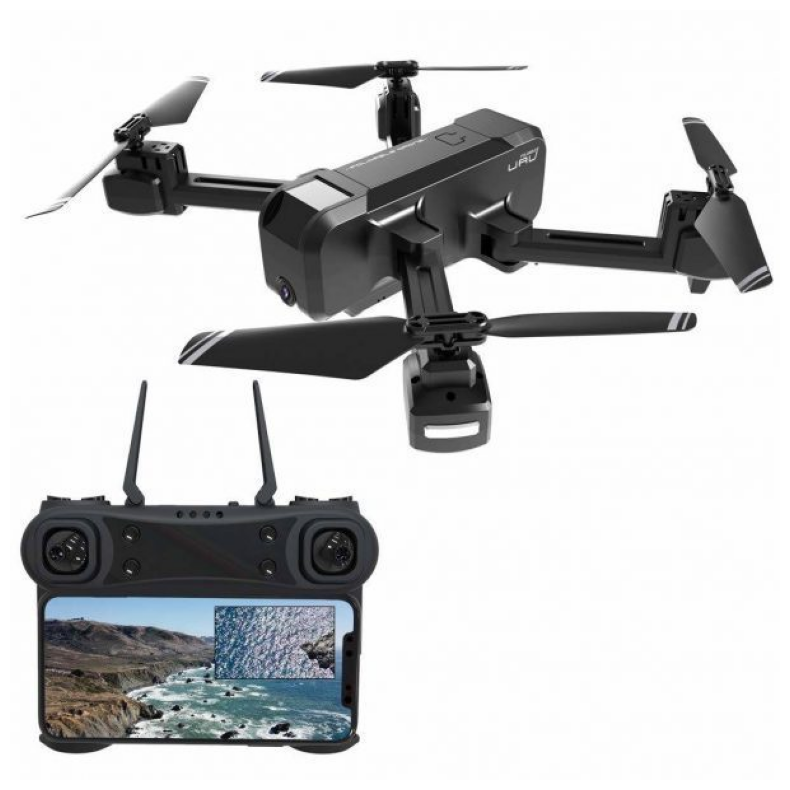

In [41]:
img_path = os.path.join(test_drone_dir, '00000153.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [42]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000095.jpg', 'drone/00000219.jpg', 'drone/00000279.jpg',
       'drone/00000303.jpg', 'drone/00000417.jpg', 'drone/00000477.jpg',
       'drone/00000525.png', 'drone/00000591.jpg', 'drone/00000652.jpg',
       'drone/00000680.jpg', 'drone/00000765.JPG', 'drone/00000799.png',
       'drone/00000893.jpg', 'drone/00000907.jpg', 'drone/00000954.jpg',
       'drone/00000978.jpg', 'drone/00000987.jpg', 'drone/00001052.jpg',
       'drone/00001210.jpg', 'drone/00001246.jpg', 'drone/00001247.jpg',
       'drone/00001277.jpg', 'drone/00001364.jpg', 'drone/00001367.jpg',
       'drone/00001370.jpg', 'drone/00001390.jpg', 'helicopter/00000129.jpg',
       'helicopter/00000153.jpg', 'helicopter/00000333.jpg',
       'helicopter/00000369.jpg', 'helicopter/00000464.jpg',
       'helicopter/00000542.jpg', 'helicopter/00000623.jpg',
       'helicopter/00000712.jpg', 'helicopter/00000895.jpg',
       'helicopter/00001188.jpeg', 'helicopter/00001363.png',
       'helicopter/00001445.jpg'

(-0.5, 1099.5, 824.5, -0.5)

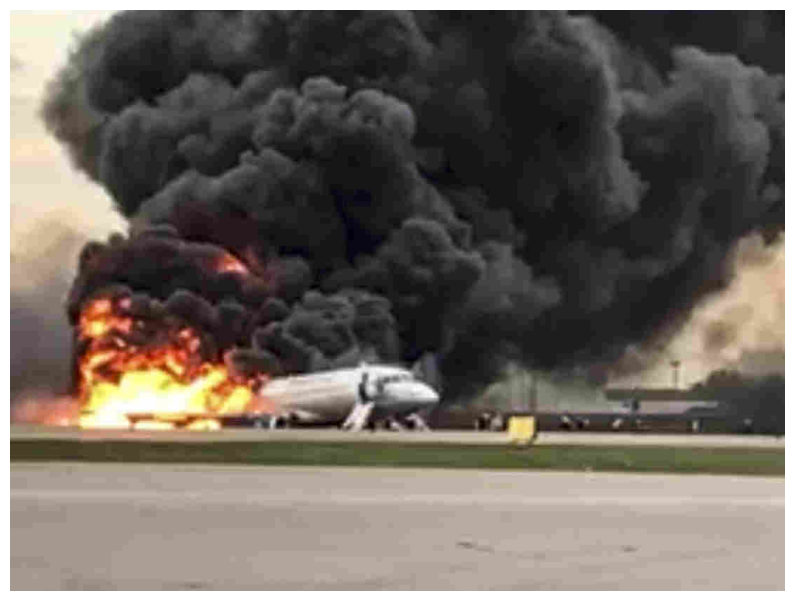

In [44]:
img_path = os.path.join(test_passenger_dir, '00001170.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [45]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000095.jpg', 'drone/00000219.jpg', 'drone/00000279.jpg',
       'drone/00000303.jpg', 'drone/00000417.jpg', 'drone/00000477.jpg',
       'drone/00000525.png', 'drone/00000591.jpg', 'drone/00000652.jpg',
       'drone/00000680.jpg', 'drone/00000765.JPG', 'drone/00000799.png',
       'drone/00000893.jpg', 'drone/00000907.jpg', 'drone/00000954.jpg',
       'drone/00000978.jpg', 'drone/00000987.jpg', 'drone/00001052.jpg',
       'drone/00001210.jpg', 'drone/00001246.jpg', 'drone/00001247.jpg',
       'drone/00001277.jpg', 'drone/00001364.jpg', 'drone/00001367.jpg',
       'drone/00001370.jpg', 'drone/00001390.jpg', 'helicopter/00000129.jpg',
       'helicopter/00000153.jpg', 'helicopter/00000333.jpg',
       'helicopter/00000369.jpg', 'helicopter/00000464.jpg',
       'helicopter/00000542.jpg', 'helicopter/00000623.jpg',
       'helicopter/00000712.jpg', 'helicopter/00000895.jpg',
       'helicopter/00001188.jpeg', 'helicopter/00001363.png',
       'helicopter/00001445.jpg'

(-0.5, 472.5, 711.5, -0.5)

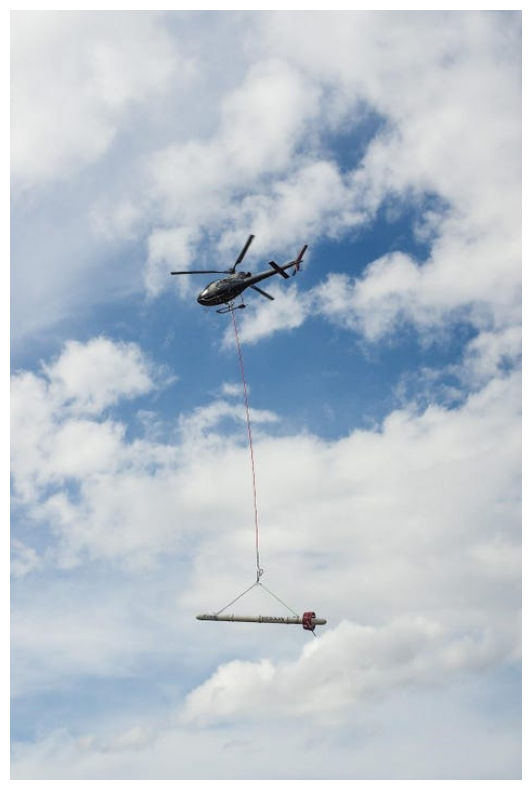

In [47]:
img_path = os.path.join(test_helicopter_dir, '00000153.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)